In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2


In [2]:
# # File paths
depth_filepath = 'data/3d_cattle_demo/renders/cow_boxed/sliding_clip_120s_v3/case=default/render=depth/front_upper/2025-08-05_173119/000021.exr'
img_filepath = 'data/3d_cattle_demo/renders/cow_boxed/sliding_clip_120s_v3/case=default/render=image/front_upper/2025-08-04_203708/000021.png'

# depth_filepath = '/home/bonting/3d_cattle_demo/data/renders/cow_boxed/sliding_clip_120s_v3/case=default/render=depth/front_upper/2025-08-06_160013/000021.exr'
# img_filepath = '/home/bonting/3d_cattle_demo/data/renders/cow_boxed/sliding_clip_120s_v3/case=default/render=image/front_upper/2025-08-06_160440/000021.png'


# Chosen point (normalized coordinates)
x_delta = 0.5  # Center of frame horizontally
y_delta = 0.5  # Center of frame vertically


In [3]:
def read_depth(filepath):
    """Read depth data from image file using OpenCV"""
    depth = cv2.imread(filepath, cv2.IMREAD_UNCHANGED)
    
    if depth is None:
        raise ValueError(f"Could not read depth image from {filepath}")
    
    height, width = depth.shape[:2]
    metadata = {}
    
    return depth, width, height, metadata


In [4]:
# Load image and depth map
img = Image.open(img_filepath)
img_array = np.array(img)

depth_map, depth_width, depth_height, exr_metadata = read_depth(depth_filepath)

print(f"Image dimensions: {img.size}")
print(f"Depth map dimensions: {depth_width} x {depth_height}")
print(f"Depth range: {depth_map.min():.3f} - {depth_map.max():.3f} meters")

# Display metadata if available
if exr_metadata:
    print("\n=== EXR Metadata ===")
    if 'camera_position' in exr_metadata:
        x, y, z = exr_metadata['camera_position']
        print(f"Camera position (world coordinates): ({x:.3f}, {y:.3f}, {z:.3f})")
    else:
        print("No camera position metadata found")
else:
    print("No custom metadata found in EXR file")

Image dimensions: (1920, 1080)
Depth map dimensions: 1920 x 1080
Depth range: 1.055 - 4.339 meters
No custom metadata found in EXR file


In [5]:
# Extract single channel depth data (cv2 loads as 3-channel but all channels are the same)
depth_data = depth_map[:, :, 0] if len(depth_map.shape) == 3 else depth_map

print(f"Depth data shape: {depth_data.shape}")
print(f"Depth range after extraction: {depth_data.min():.3f} - {depth_data.max():.3f} meters")


Depth data shape: (1080, 1920)
Depth range after extraction: 1.055 - 4.339 meters


In [6]:
# # Convert normalized coordinates to pixel coordinates
# img_width, img_height = img.size
# x_pixel = int(x_delta * img_width)
# y_pixel = int(y_delta * img_height)

# # For depth map coordinates (in case dimensions differ)
# x_depth_pixel = int(x_delta * depth_width)
# y_depth_pixel = int(y_delta * depth_height)

# Chosen point manual values
x_pixel = x_depth_pixel = 959
y_pixel = y_depth_pixel = 75

# Get distance at chosen point using extracted depth data
distance_meters = depth_data[y_depth_pixel, x_depth_pixel]

print(f"Chosen point coordinates:")
print(f"  Image: ({x_pixel}, {y_pixel}) pixels")
print(f"  Depth: ({x_depth_pixel}, {y_depth_pixel}) pixels")
print(f"Distance from viewer: {distance_meters:.3f} meters")


Chosen point coordinates:
  Image: (959, 75) pixels
  Depth: (959, 75) pixels
Distance from viewer: 2.714 meters


In [7]:
print(f"Max depth value in file: {depth_data.max():.3f} meters")


Max depth value in file: 4.339 meters


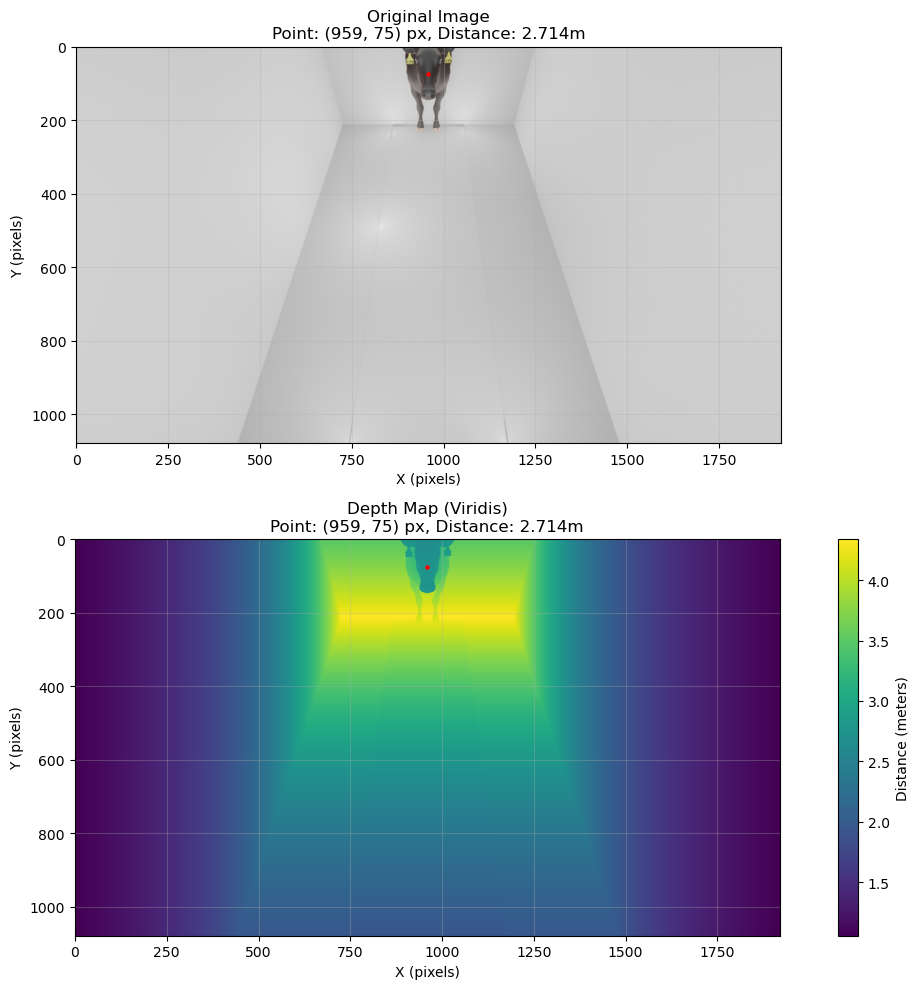

In [8]:
# Create visualization
DOT_SIZE = 5

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Top plot: Original image
ax1.imshow(img_array)
ax1.scatter(x_pixel, y_pixel, c='red', s=DOT_SIZE, marker='o')
ax1.set_title(f'Original Image\nPoint: ({x_pixel}, {y_pixel}) px, Distance: {distance_meters:.3f}m')
ax1.set_xlabel('X (pixels)')
ax1.set_ylabel('Y (pixels)')
ax1.grid(True, alpha=0.3)

# Bottom plot: Depth map
depth_plot = ax2.imshow(depth_data, cmap='viridis')
ax2.scatter(x_depth_pixel, y_depth_pixel, c='red', s=DOT_SIZE, marker='o')
ax2.set_title(f'Depth Map (Viridis)\nPoint: ({x_depth_pixel}, {y_depth_pixel}) px, Distance: {distance_meters:.3f}m')
ax2.set_xlabel('X (pixels)')
ax2.set_ylabel('Y (pixels)')

# Add colorbar for depth map
cbar = plt.colorbar(depth_plot, ax=ax2)
cbar.set_label('Distance (meters)')

ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [9]:
# Additional analysis
print("\n=== Analysis Summary ===")
print(f"Chosen normalized coordinates: ({x_delta}, {y_delta})")
print(f"Pixel coordinates in image: ({x_pixel}, {y_pixel})")
print(f"Pixel coordinates in depth map: ({x_depth_pixel}, {y_depth_pixel})")
print(f"Distance to surface: {distance_meters:.3f} meters")

# Include camera metadata in analysis
if exr_metadata and 'camera_position' in exr_metadata:
    cam_x, cam_y, cam_z = exr_metadata['camera_position']
    print(f"Camera world position: ({cam_x:.3f}, {cam_y:.3f}, {cam_z:.3f})")
    
    # Calculate distance from camera origin to selected point if we have camera position
    # Note: This is approximate as it assumes the depth is along the camera's forward vector
    print(f"Approximate 3D distance from camera origin: {np.sqrt(cam_x**2 + cam_y**2 + cam_z**2 + distance_meters**2):.3f}m")

print(f"Depth map statistics:")
print(f"  - Min distance: {depth_data.min():.3f}m")
print(f"  - Max distance: {depth_data.max():.3f}m")
print(f"  - Mean distance: {depth_data.mean():.3f}m")
print(f"  - Std deviation: {depth_data.std():.3f}m")



=== Analysis Summary ===
Chosen normalized coordinates: (0.5, 0.5)
Pixel coordinates in image: (959, 75)
Pixel coordinates in depth map: (959, 75)
Distance to surface: 2.714 meters
Depth map statistics:
  - Min distance: 1.055m
  - Max distance: 4.339m
  - Mean distance: 2.130m
  - Std deviation: 0.839m
